# U.S. Medical Insurance Costs

My goals here are to see if I can predict medical issurance cost based on the data provided.  Since I know in real life there is some kind of algorithim, my goal is to reconstruct it.  The data are a mix of numerical (age, BMI, number of children, insurance cost) and categorical (sex, region, smoker status).  I want to at least examine each variable for single-variable trends, but I also want to write functions that allow for multi-variate analysis using two varaibles, and test those out.  

I already know something about numpy and matplotlib, which allows for more efficient use of numerical anaylysis and plotting respectively. 

Also using dictionaries to format the data might be useful, but I'll have to assign a User ID number (probably just the row the entry came in) to allow for accessing the data.  A function to pull up an individual entry, or to search for users with a given statistic would be handy. (Table this for another project;)

In [5]:
import csv
import numpy
import scipy.optimize as spo
import matplotlib.pyplot as plt
ages = []
sexes = []
bmis = []
num_children = []
smokerstatus = []
regions = []
insurance_cost = []
insurance_dict = {}
idnumber = 0
with open('insurance.csv') as csvfile:
    csv_insurance = csv.DictReader(csvfile)
    for row in csv_insurance:
        insurance_dict[idnumber] = row
        idnumber += 1
        
for entry in insurance_dict:
    row = insurance_dict[entry]
    row["age"] = int(row["age"])
    row["bmi"] = float(row["bmi"])
    row["children"] = int(row["children"])
    row["charges"] = float(row["charges"])
    ages.append(row["age"]) 
    bmis.append(row["bmi"])
    num_children.append(row["children"]) 
    insurance_cost.append(row["charges"])
    sexes.append(row["sex"])
    smokerstatus.append(row["smoker"])
    regions.append(row["region"])
        
#Note for later: validate the data!!!

The first thing I like to do with data is just do some scatter plots; the relevant variable here is that I want to estimate insurance cost from the data here, which means I'm going to take the numerical data and just plot cos vs. each.

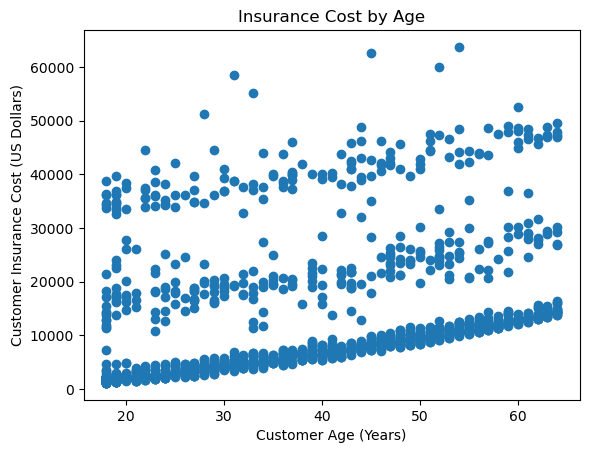

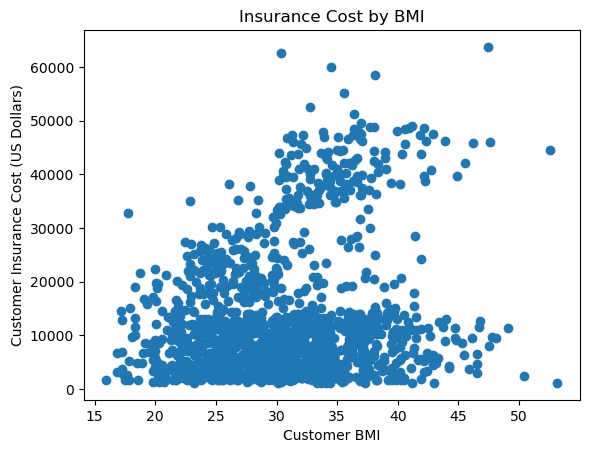

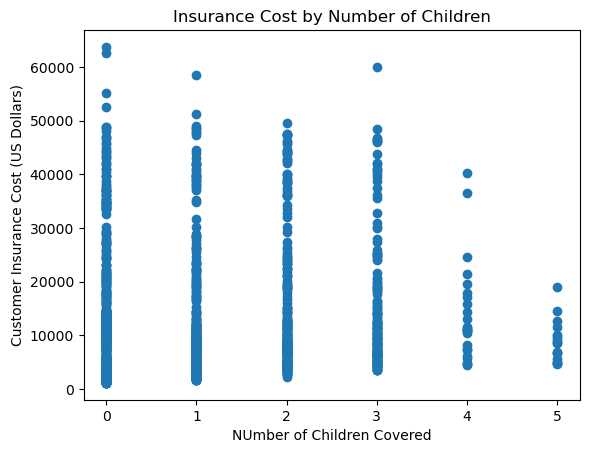

In [6]:
age_oned = plt.scatter(ages,insurance_cost)
plt.title("Insurance Cost by Age")
plt.xlabel("Customer Age (Years)")
plt.ylabel("Customer Insurance Cost (US Dollars)")
plt.show(age_oned)

bmi_oned = plt.scatter(bmis,insurance_cost)
plt.title("Insurance Cost by BMI")
plt.xlabel("Customer BMI")
plt.ylabel("Customer Insurance Cost (US Dollars)")
plt.show(bmi_oned)

kids_oned = plt.scatter(num_children,insurance_cost)
plt.title("Insurance Cost by Number of Children")
plt.xlabel("NUmber of Children Covered")
plt.ylabel("Customer Insurance Cost (US Dollars)")
plt.show(kids_oned)

That's certainly interesting.  The first plot (insurance cost by age) shows at least three clear lines, with some outliers.  There's clearly a trend with age, but there's some very distinct co-founders.

The BMI plot is messy, with three clouds (though I can't tell if the 'low BMI high cost' and 'high BMI high cost' are the same distribution).

The 'number of children' is interesting because while the minimum goes up by a bit, the maximum goes down by a LOT.  
My intuition is to now check the 'smoker status' variable, as I suspect that is pretty important, and that it might make sense to divide the data by that.  As a quick look, I'm just going to color-code things.  Right now, I'm not focusing on making the plots pretty, just enough to be functional for people who are not me.  (An old habit from grad school and printing off plots to show to my advisor.)

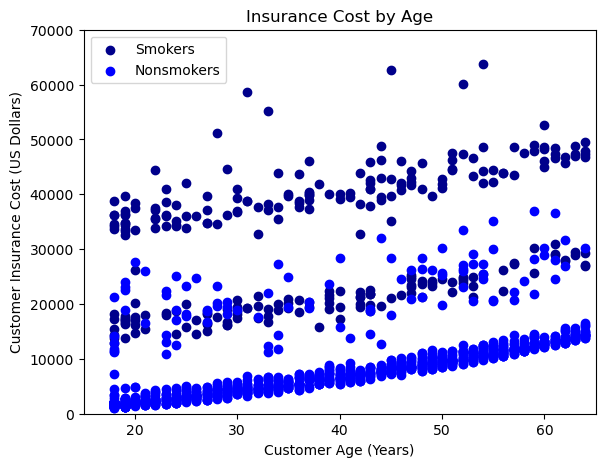

In [7]:
#I don't need to divide the data yet.  I can just color code it.

ages_smokers = []
ages_nonsmokers = []
cost_smokers = []
cost_nonsmokers = []
for entry in insurance_dict:
    row = insurance_dict[entry]
    if row["smoker"] == "no":
        ages_nonsmokers.append(row["age"]) 
        cost_nonsmokers.append(row["charges"])
    else:
        ages_smokers.append(row["age"])
        cost_smokers.append(row["charges"])

plt.axes([0.1, 0.1, 0.8, 0.8]) 
plt.scatter(ages_smokers,cost_smokers,c = "darkblue")
plt.scatter(ages_nonsmokers,cost_nonsmokers,c = "blue")
plt.xlim([15,65])
plt.ylim([0,70000])
plt.title("Insurance Cost by Age")
plt.xlabel("Customer Age (Years)")
plt.ylabel("Customer Insurance Cost (US Dollars)")
plt.legend(["Smokers" , "Nonsmokers"])
plt.show()

Certainly promising.  And we now know there's a second category to look at.  Sex seems the obvious choice, since it is binary in this data set.  I'm going to do something a bit more contained, so I don't need to chop and dice the data into more variables

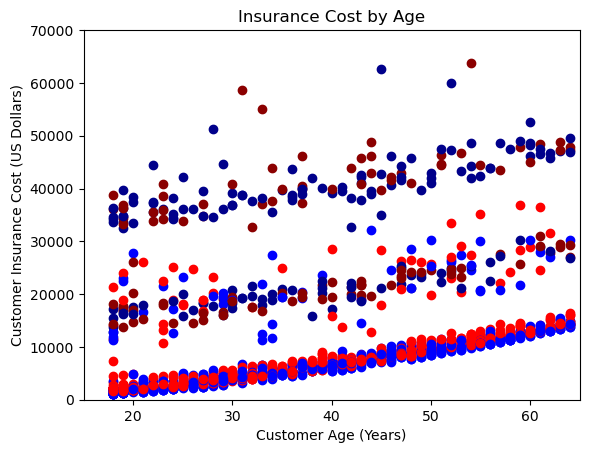

In [8]:
plt.xlim([15,65])
plt.ylim([0,70000])
plt.title("Insurance Cost by Age")
plt.xlabel("Customer Age (Years)")
plt.ylabel("Customer Insurance Cost (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    if (row["smoker"] == "no" and row["sex"] == "female"):
        plt.scatter(row["age"],row["charges"],c = "red")
    elif (row["smoker"] == "no" and row["sex"] == "male"):
        plt.scatter(row["age"],row["charges"],c = "blue")
    elif (row["smoker"] == "yes" and row["sex"] == "female"):
        plt.scatter(row["age"],row["charges"],c = "darkred")
    else:
        plt.scatter(row["age"],row["charges"],c = "darkblue")

plt.show()

#Add in key here

It's not sex, that's for sure. Let's look at the BMI plot with this same color coding.  We noticed something there.

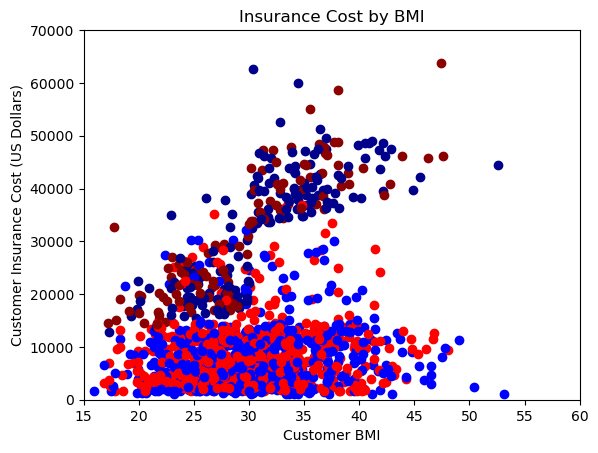

In [9]:
plt.xlim([15,60])
plt.ylim([0,70000])
plt.title("Insurance Cost by BMI")
plt.xlabel("Customer BMI")
plt.ylabel("Customer Insurance Cost (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    if (row["smoker"] == "no" and row["sex"] == "female"):
        plt.scatter(row["bmi"],row["charges"],c = "red")
    elif (row["smoker"] == "no" and row["sex"] == "male"):
        plt.scatter(row["bmi"],row["charges"],c = "blue")
    elif (row["smoker"] == "yes" and row["sex"] == "female"):
        plt.scatter(row["bmi"],row["charges"],c = "darkred")
    else:
        plt.scatter(row["bmi"],row["charges"],c = "darkblue")

plt.show()

Bingo!  The big breakdown in prediction insurance rates is that smokers are charged more... but smokers with a BMI of greater than 30 or so are charged a LOT more.  So the next step is to see what that gets us if we subtract the effects.  How I'm going to do that is divide the data into 'nonsmoker', 'low-bmi smoker' and 'high-bmi smoker' and then get the averages.  Then I can predict what the other two would pay if they were in the non-smoker category.

The first step is to segregate the data into smoker and non-smoker, then confirm the BMI is doing what I think it is.

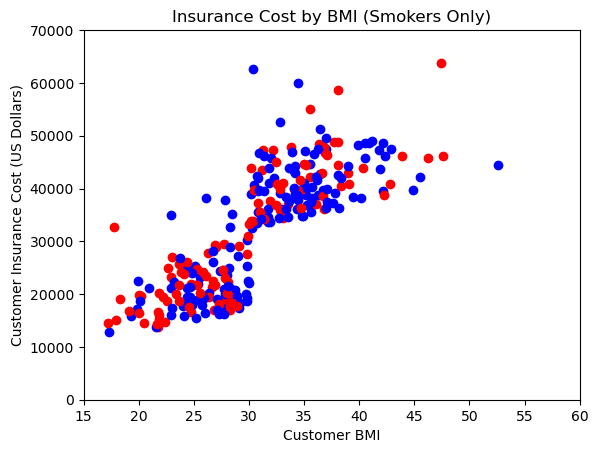

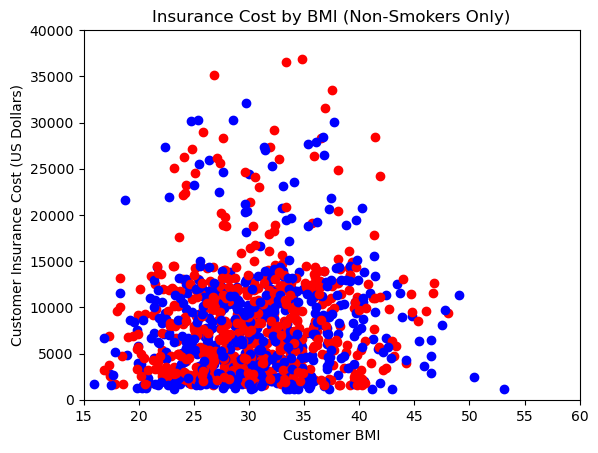

In [10]:
id_smoker_lowbmi = []
id_smoker_highbmi = []
id_nonsmokers = []
cost_nonsmokers = []
cost_smoker_lowbmi = []
cost_smoker_highbmi = []
bmi_smoker_lowbmi = []
bmi_smoker_highbmi = []
for entry in insurance_dict:
    row = insurance_dict[entry]
    if (row["smoker"] == "yes"):
        if (row["bmi"] <= 30.):
            id_smoker_lowbmi.append(entry)
            cost_smoker_lowbmi.append(row["charges"])
            bmi_smoker_lowbmi.append(row["bmi"])
        else:
            id_smoker_highbmi.append(entry)
            cost_smoker_highbmi.append(row["charges"])
            bmi_smoker_highbmi.append(row["bmi"])
    else:
        id_nonsmokers.append(entry)
        cost_nonsmokers.append(row["charges"])

plt.xlim([15,60])
plt.ylim([0,70000])
plt.title("Insurance Cost by BMI (Smokers Only)")
plt.xlabel("Customer BMI")
plt.ylabel("Customer Insurance Cost (US Dollars)")
        
for entry in insurance_dict:
    row = insurance_dict[entry]
    if (row["smoker"] == "yes"):
        if row["sex"] == "female":
            plt.scatter(row["bmi"],row["charges"],c = "red")
        else:
            plt.scatter(row["bmi"],row["charges"],c = "blue")

plt.show()

plt.xlim([15,60])
plt.ylim([0,40000])
plt.title("Insurance Cost by BMI (Non-Smokers Only)")
plt.xlabel("Customer BMI")
plt.ylabel("Customer Insurance Cost (US Dollars)")
        
for entry in insurance_dict:
    row = insurance_dict[entry]
    if (row["smoker"] == "no"):
        if row["sex"] == "female":
            plt.scatter(row["bmi"],row["charges"],c = "red")
        else:
            plt.scatter(row["bmi"],row["charges"],c = "blue")

plt.show()

Looking at the data for smokers on its own, it's not a clean 'two groups' but something that looks like a linear trend that is piecewise, with a discontinuity at BMI = 30.   

Numpy already gives us a way to fit a line, so we'll use that rather than reinventing the wheel.  

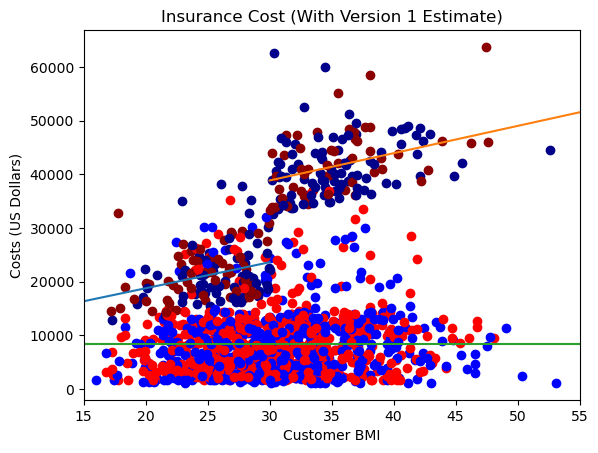

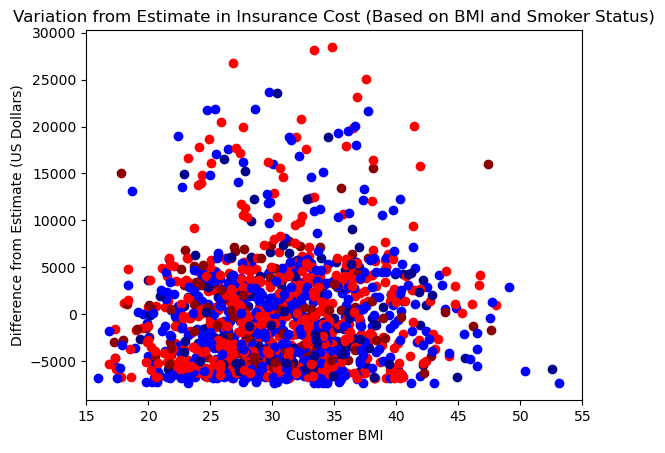

In [11]:
smoker_lowbmi_coeff = numpy.polyfit(bmi_smoker_lowbmi,cost_smoker_lowbmi, deg = 1)
smoker_highbmi_coeff = numpy.polyfit(bmi_smoker_highbmi,cost_smoker_highbmi, deg = 1)
nonsmoker_coeff = [0,numpy.average(cost_nonsmokers)]

def insurance_estimate_v1(insurance_entry):
    if (insurance_entry["smoker"] == "yes"):
        if (insurance_entry["bmi"] <= 30.):
            return smoker_lowbmi_coeff[0]*insurance_entry["bmi"]+smoker_lowbmi_coeff[1]
        else:
            return smoker_highbmi_coeff[0]*insurance_entry["bmi"]+smoker_highbmi_coeff[1]
    else:
        return nonsmoker_coeff[1]
    
    
plt.xlim([15,55])
plt.title("Insurance Cost (With Version 1 Estimate)")
plt.xlabel("Customer BMI")
plt.ylabel("Costs (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    if (row["smoker"] == "no" and row["sex"] == "female"):
        plt.scatter(row["bmi"],row["charges"],c = "red")
    elif (row["smoker"] == "no" and row["sex"] == "male"):
        plt.scatter(row["bmi"],row["charges"],c = "blue")
    elif (row["smoker"] == "yes" and row["sex"] == "female"):
        plt.scatter(row["bmi"],row["charges"],c = "darkred")
    else:
        plt.scatter(row["bmi"],row["charges"],c = "darkblue")
        
plt.plot([0,30], [smoker_lowbmi_coeff[1],smoker_lowbmi_coeff[0]*30+smoker_lowbmi_coeff[1]])        
plt.plot([30,55], [smoker_highbmi_coeff[1]+smoker_highbmi_coeff[0]*30,smoker_highbmi_coeff[0]*55+smoker_highbmi_coeff[1]])        
plt.plot([0,55], [nonsmoker_coeff[1],nonsmoker_coeff[1]])        

plt.show()

plt.xlim([15,55])
plt.title("Variation from Estimate in Insurance Cost (Based on BMI and Smoker Status)")
plt.xlabel("Customer BMI")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v1(row)
    if (row["smoker"] == "no" and row["sex"] == "female"):
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "red")
    elif (row["smoker"] == "no" and row["sex"] == "male"):
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "blue")
    elif (row["smoker"] == "yes" and row["sex"] == "female"):
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "darkred")
    else:
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "darkblue")

Okay, our next step is to account for age.  Let's see how our estimate works with age.  I'll turn off color-coding for smoker status or BMI, but I might turn it back on if I notice some odd things. 

Strictly speaking, we should probably fit this as a 2 or 3-D problem, but let's see how well we can do with a series of 1D fits

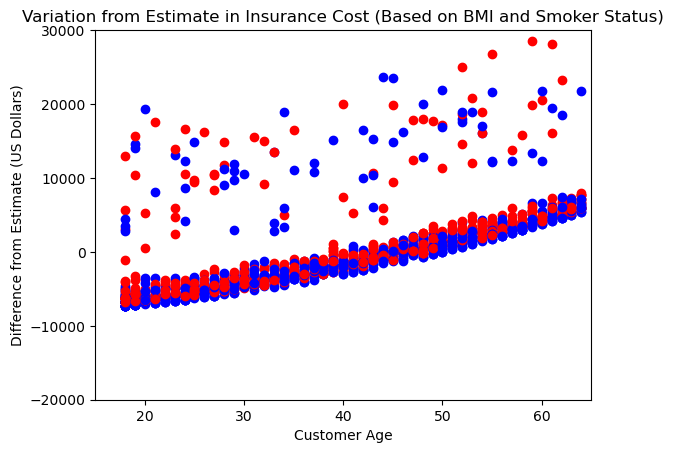

In [12]:
plt.xlim([15,65])
plt.ylim([-20000,30000])
plt.title("Variation from Estimate in Insurance Cost (Based on BMI and Smoker Status)")
plt.xlabel("Customer Age")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v1(row)
    if (row["sex"] == "female"):
        plt.scatter(row["age"],row["charges"]-est_cost,c = "red")
    else:
        plt.scatter(row["age"],row["charges"]-est_cost,c = "blue")
        
plt.show()

Whatever is causing those increased costs is really distracting.  Let's go back and try to identify those, but let's do a simple subtraction of the effect of age first.  Eyeballing it makes me think it's not linear, but since I want to chase down these outliers, I'm not going to bother with a more complicated fit.  I'm also starting to see the effect of sex, but we're going to table that unless we need to clear that up next.

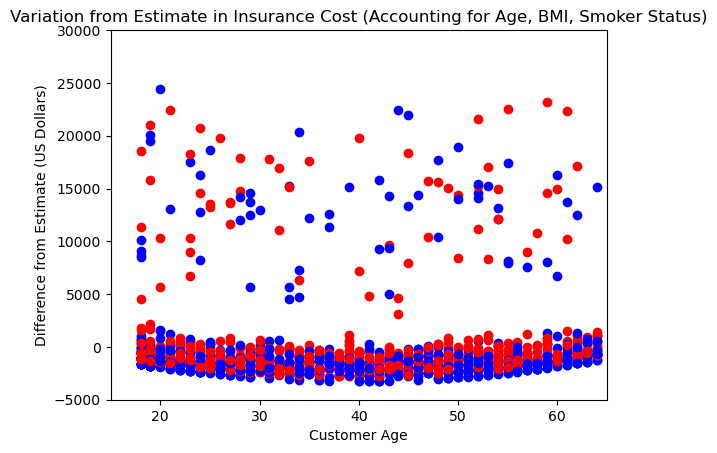

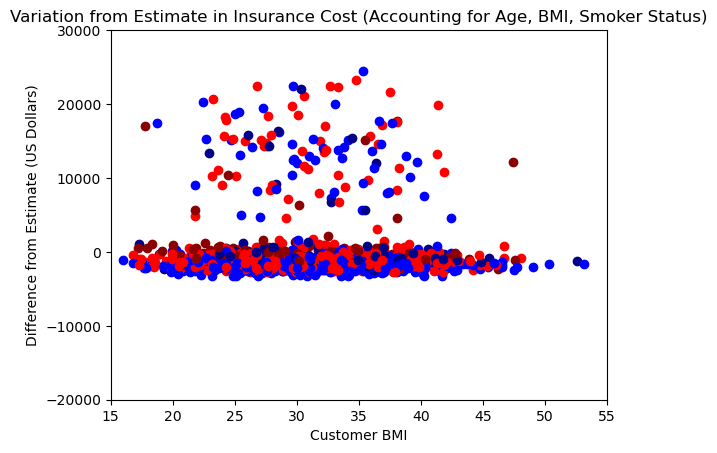

In [13]:
cost_variation_v1 = []

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v1(row)
    cost_variation_v1.append(row["charges"]-est_cost)
    
age_coeff = numpy.polyfit(ages,cost_variation_v1, deg = 1)

def insurance_estimate_v2(insurance_entry):
    if (insurance_entry["smoker"] == "yes"):
        if (insurance_entry["bmi"] <= 30.):
            estimate =  smoker_lowbmi_coeff[0]*insurance_entry["bmi"]+smoker_lowbmi_coeff[1]
        else:
            estimate = smoker_highbmi_coeff[0]*insurance_entry["bmi"]+smoker_highbmi_coeff[1]
    else:
        estimate =  nonsmoker_coeff[1]
    estimate = estimate + (age_coeff[1]+age_coeff[0]*insurance_entry["age"])
    return estimate

plt.xlim([15,65])
plt.ylim([-5000,30000])
plt.title("Variation from Estimate in Insurance Cost (Accounting for Age, BMI, Smoker Status)")
plt.xlabel("Customer Age")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v2(row)
    if (row["sex"] == "female"):
        plt.scatter(row["age"],row["charges"]-est_cost,c = "red")
    else:
        plt.scatter(row["age"],row["charges"]-est_cost,c = "blue")
        
plt.show()

plt.xlim([15,55])
plt.ylim([-20000,30000])
plt.title("Variation from Estimate in Insurance Cost (Accounting for Age, BMI, Smoker Status)")
plt.xlabel("Customer BMI")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v2(row)
    if (row["smoker"] == "no" and row["sex"] == "female"):
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "red")
    elif (row["smoker"] == "no" and row["sex"] == "male"):
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "blue")
    elif (row["smoker"] == "yes" and row["sex"] == "female"):
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "darkred")
    else:
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "darkblue")    
        
plt.show()

... Okay, I do need to account for a non-linear trend in age, but let's chase down those outliers first and understand why they are outliers.  I also suspect there may be some multivariate effects in there.  We've examined age, BMI and smoker status (and while we've not examined gender in detail, we do plot it), so let's table those for now.  The other factors in our database are 'number of children' and 'region'.  Let's see if these people who pay more for insurance than expected have either of those factors in common.  That means going back to our number of children plot, and looking at how the estimate does.

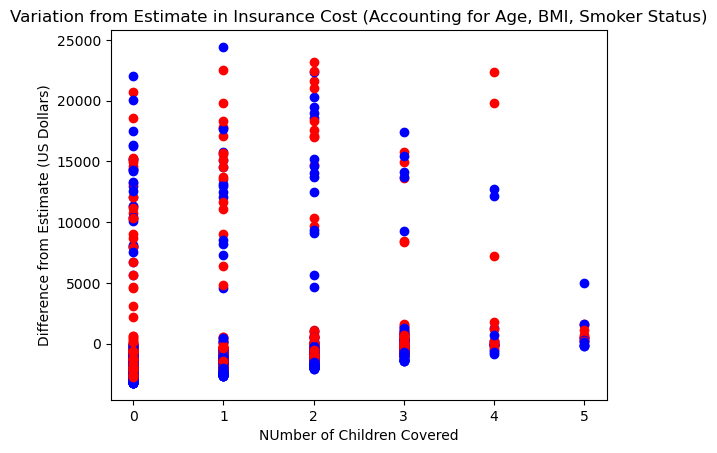

In [14]:
plt.title("Variation from Estimate in Insurance Cost (Accounting for Age, BMI, Smoker Status)")
plt.xlabel("NUmber of Children Covered")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v2(row)
    if (row["sex"] == "female"):
        plt.scatter(row["children"],row["charges"]-est_cost,c = "red")
    else:
        plt.scatter(row["children"],row["charges"]-est_cost,c = "blue")


Well, there does seem to be a trend in number of children, but it doesn't solve our outlier problem.  Next case, regions.  If we can't find anything, because the data have outliers only on one side, we need to account for that in coming up with our model.  

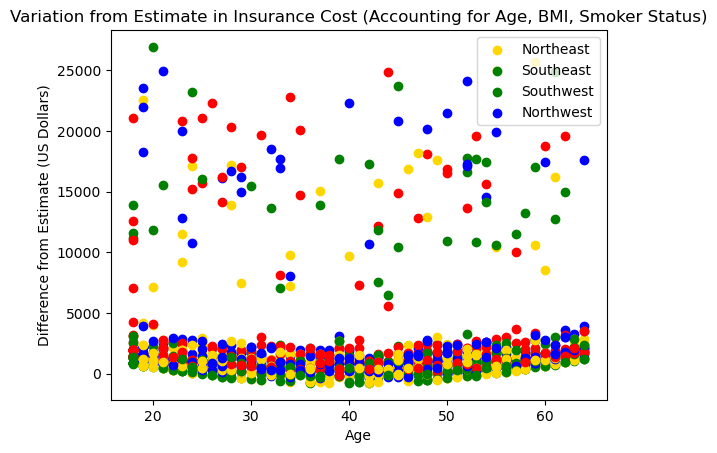

In [68]:
plt.title("Variation from Estimate in Insurance Cost (Accounting for Age, BMI, Smoker Status)")
plt.xlabel("Age")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v2(row)
    if (row["region"] == "northeast"):
        plt.scatter(row["age"],row["charges"]-est_cost,c = "red")
    elif (row["region"] == "southeast"):
        plt.scatter(row["age"],row["charges"]-est_cost,c = "green")
    elif (row["region"] == "southwest"):
        plt.scatter(row["age"],row["charges"]-est_cost,c = "gold")
    else:
        plt.scatter(row["age"],row["charges"]-est_cost,c = "blue")

plt.legend(["Northeast" , "Southeast","Southwest","Northwest"])
plt.show()

#Fix the legend

Nope!  My intuition is that these folks have some other medical condition that has raised their rates by a lot, so we can't predict them from the current data.  A distribution where only one side has a long tail is a pain in the neck to work with.  Identifying them might be useful, but for now, let's set them aside (metaphorically speaking) and continue our model. 

This is something I want to chew on a bit for how best to handle them.  It might be the best idea to create a new data set without the outliers for now, and get my funciton working.  Let's get the mean and STDEV of the residuals and see how that looks.

In [16]:
residuals = []

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v2(row)
    residuals.append(row["charges"]-est_cost)

avg_residual = numpy.average(residuals)
stdev_residual = numpy.std(residuals)
print(avg_residual, stdev_residual)

-4.774507313343085e-12 4454.727097018941


Well, nuts.  The data are enough to skew the standard deviation.  I was hoping to be less arbitrary, but I'm going to make a cut at around +2500 over the model.  

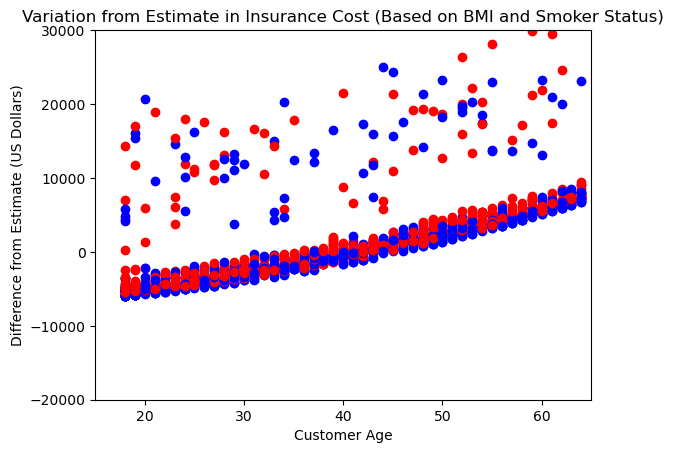

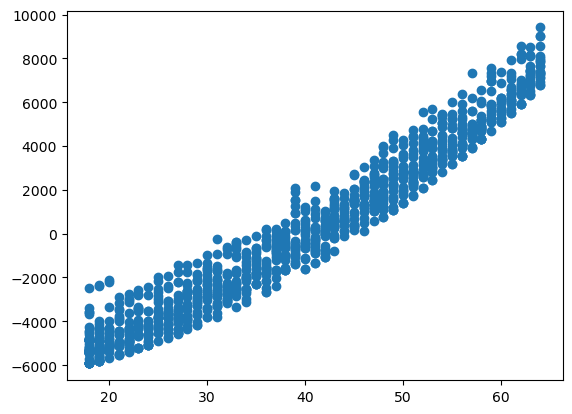

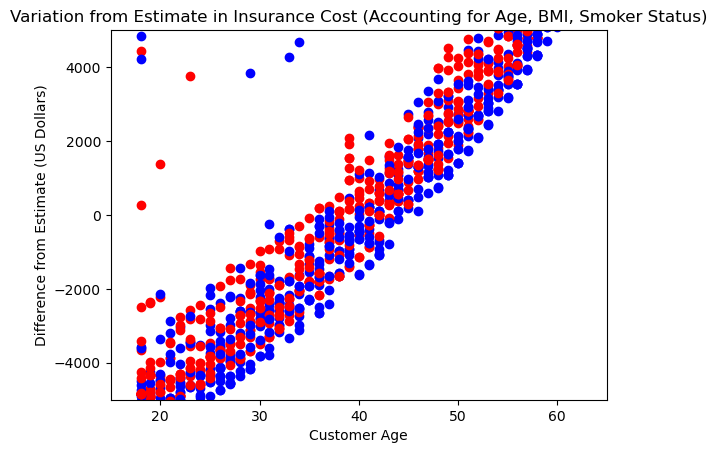

In [17]:
wellmodeled_insurance_dict = {}
for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v2(row)
    if (row["charges"] -est_cost < 2500):
        wellmodeled_insurance_dict[entry] = row

wm_cost_nonsmoker = []
wm_cost_smoker_lowbmi = []
wm_cost_smoker_highbmi = []
wm_bmi_smoker_lowbmi = []
wm_bmi_smoker_highbmi = []
wm_age_nonsmoker = []
wm_age_smoker_lowbmi = []
wm_age_smoker_highbmi = []
for entry in wellmodeled_insurance_dict:
    row = wellmodeled_insurance_dict[entry]
    if (row["smoker"] == "yes"):
        if (row["bmi"] <= 30.):
            wm_cost_smoker_lowbmi.append(row["charges"])
            wm_bmi_smoker_lowbmi.append(row["bmi"])
            wm_age_smoker_lowbmi.append(row["age"])
        else:
            wm_cost_smoker_highbmi.append(row["charges"])
            wm_bmi_smoker_highbmi.append(row["bmi"])
            wm_age_smoker_highbmi.append(row["age"])
    else:
        wm_cost_nonsmoker.append(row["charges"])
        wm_age_nonsmoker.append(row["age"])
        
wm_smoker_lowbmi_coeff = numpy.polyfit(wm_bmi_smoker_lowbmi,wm_cost_smoker_lowbmi, deg = 1)
wm_smoker_highbmi_coeff = numpy.polyfit(wm_bmi_smoker_highbmi,wm_cost_smoker_highbmi, deg = 1)
wm_nonsmoker_coeff = [0,numpy.average(wm_cost_nonsmoker)]

def insurance_estimate_v3dot0(insurance_entry):
    if (insurance_entry["smoker"] == "yes"):
        if (insurance_entry["bmi"] <= 30.):
            return wm_smoker_lowbmi_coeff[0]*insurance_entry["bmi"]+wm_smoker_lowbmi_coeff[1]
        else:
            return wm_smoker_highbmi_coeff[0]*insurance_entry["bmi"]+wm_smoker_highbmi_coeff[1]
    else:
        return wm_nonsmoker_coeff[1]
    
plt.xlim([15,65])
plt.ylim([-20000,30000])
plt.title("Variation from Estimate in Insurance Cost (Based on BMI and Smoker Status)")
plt.xlabel("Customer Age")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v3dot0(row)
    if (row["sex"] == "female"):
        plt.scatter(row["age"],row["charges"]-est_cost,c = "red")
    else:
        plt.scatter(row["age"],row["charges"]-est_cost,c = "blue")
        
plt.show()

cost_variation_v3 = []
wm_ages = []

for entry in wellmodeled_insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v3dot0(row)
    wm_ages.append(row["age"])
    cost_variation_v3.append(row["charges"]-est_cost)
    
plt.scatter(wm_ages,cost_variation_v3)
plt.show()

def monoExp(x, a, b, c):
    return a * numpy.exp(b * x) + c
    
temp_coeff, temp_covar = spo.curve_fit(monoExp,wm_ages,cost_variation_v3)
#print(temp_coeff)

#wm_age_coeff = [6.53960457e-15,  9.99999995e-01, -4.70560463e+03]

def insurance_estimate_v3dot1(insurance_entry):
    if (insurance_entry["smoker"] == "yes"):
        if (insurance_entry["bmi"] <= 30.):
            working_estimate =  wm_smoker_lowbmi_coeff[0]*insurance_entry["bmi"]+wm_smoker_lowbmi_coeff[1]
        else:
            working_estimate =   wm_smoker_highbmi_coeff[0]*insurance_entry["bmi"]+wm_smoker_highbmi_coeff[1]
    else:
        working_estimate =   wm_nonsmoker_coeff[1]
#    working_estimate += monoExp(row["age"],wm_age_coeff[0],wm_age_coeff[1],wm_age_coeff[2])
    return working_estimate

plt.xlim([15,65])
plt.ylim([-5000,5000])
plt.title("Variation from Estimate in Insurance Cost (Accounting for Age, BMI, Smoker Status)")
plt.xlabel("Customer Age")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v3dot1(row)
    if (row["sex"] == "female"):
        plt.scatter(row["age"],row["charges"]-est_cost,c = "red")
    else:
        plt.scatter(row["age"],row["charges"]-est_cost,c = "blue")
        
plt.show()

Okay, I have no idea why the exponential fitting routine for age isn't working. Let's go with a sufficiently fiddly polynomial.  (In theory, I can show that is an exponential function; hooray for calculus!)

[ 1.36195673e-03 -2.13194117e-01  1.39103971e+01 -1.69335021e+02
 -5.48957812e+03]


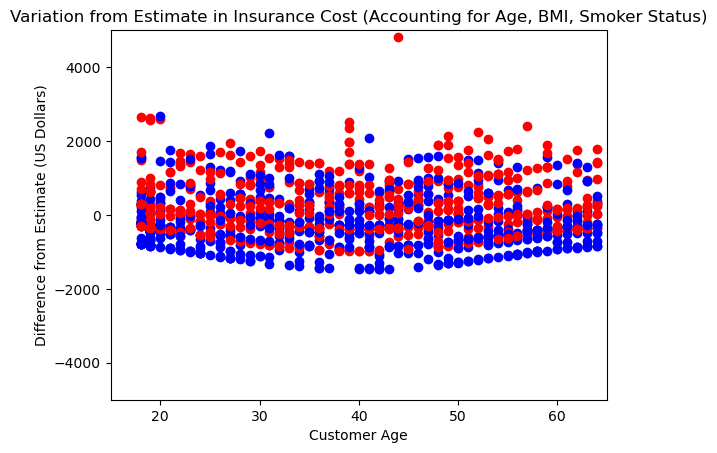

In [18]:
wm_age_coeff= numpy.polyfit(wm_ages,cost_variation_v3, deg = 4)
print(wm_age_coeff)

def insurance_estimate_v3dot2(insurance_entry):
    if (row["smoker"] == "yes"):
        if (row["bmi"] <= 30.):
            working_estimate =  wm_smoker_lowbmi_coeff[0]*row["bmi"]+wm_smoker_lowbmi_coeff[1]
        else:
            working_estimate =   wm_smoker_highbmi_coeff[0]*row["bmi"]+wm_smoker_highbmi_coeff[1]
    else:
        working_estimate =   wm_nonsmoker_coeff[1]
    age = row["age"]
    working_estimate += (age**4)*wm_age_coeff[0]+(age**3)*wm_age_coeff[1]+(age**2)*wm_age_coeff[2]+age*wm_age_coeff[3]+wm_age_coeff[4]
    return working_estimate

plt.xlim([15,65])
plt.ylim([-5000,5000])
plt.title("Variation from Estimate in Insurance Cost (Accounting for Age, BMI, Smoker Status)")
plt.xlabel("Customer Age")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v3dot2(row)
    if (row["sex"] == "female"):
        plt.scatter(row["age"],row["charges"]-est_cost,c = "red")
    else:
        plt.scatter(row["age"],row["charges"]-est_cost,c = "blue")
        
plt.show()

Really what I want to do is do the age last, but I'm worried about how different subsamples handle age.  I can check that, though.  Let's do some histograms of sex, region and number of children to see if the age distribution looks the same.  These are going to be ugly plots.

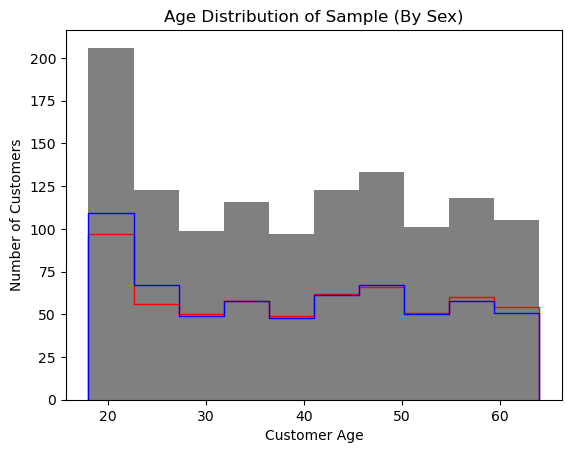

In [19]:
bin_edges = [15.,20,25,30,35,40,45,50,55]
counts, bins = numpy.histogram(wm_ages)
plt.title("Age Distribution of Sample (By Sex)")
plt.xlabel("Customer Age")
plt.ylabel("Number of Customers")
plt.stairs(counts, bins, fill=True, fc="gray")

wm_age_female = [] 
wm_age_male = [] 
for entry in wellmodeled_insurance_dict:
    row = wellmodeled_insurance_dict[entry]
    if (row["sex"] == "female"):
        wm_age_female.append(row["age"])
    else:
        wm_age_male.append(row["age"])
        
counts, bins = numpy.histogram(wm_age_female)
plt.stairs(counts, bins, ec="red")

counts, bins = numpy.histogram(wm_age_male)
plt.stairs(counts, bins, ec="blue")
plt.show()


Okay, it might be useful to look at the difference between ages 30 and 50 in the sample, where the sexes are pretty even.  I wonder why more men than women are insured at younger ages, while slightly more women than men at older ages (women live longer? a difference in marriage patterns? women more likely to be in college, so still on their parents plants?).  I also wonder if the first bin is over-represented because the youngest cohort is more likely to be unmarried (so each member of a couple has thier own plan, rather than having a spouse on the better plan).  Let's check regions and number of kids.

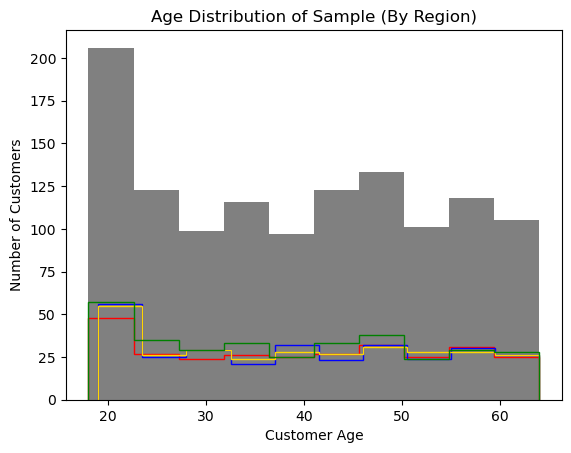

In [20]:
bin_edges = [15.,20,25,30,35,40,45,50,55]
counts, bins = numpy.histogram(wm_ages)
plt.title("Age Distribution of Sample (By Region)")
plt.xlabel("Customer Age")
plt.ylabel("Number of Customers")
plt.stairs(counts, bins, fill=True, fc="gray")

wm_age_ne = [] 
wm_age_nw = [] 
wm_age_sw = [] 
wm_age_se = [] 
for entry in wellmodeled_insurance_dict:
    row = wellmodeled_insurance_dict[entry]
    if (row["region"] == "northeast"):
        wm_age_ne.append(row["age"])
    elif (row["region"] == "northwest"):
        wm_age_nw.append(row["age"])
    elif (row["region"] == "southwest"):
        wm_age_sw.append(row["age"])
    else:
        wm_age_se.append(row["age"])
        
counts, bins = numpy.histogram(wm_age_ne)
plt.stairs(counts, bins, ec="red")

counts, bins = numpy.histogram(wm_age_nw)
plt.stairs(counts, bins, ec="blue")

counts, bins = numpy.histogram(wm_age_sw)
plt.stairs(counts, bins, ec="gold")

counts, bins = numpy.histogram(wm_age_se)
plt.stairs(counts, bins, ec="green")
plt.show()

Those look mostly flat, but I might stick to the 30-50 range to avoid some of the problems I noticed.  Now for kids.  I suspect I'm going to need an age range here, as the very young and very old members of the sample are unlikely to have kids on their plans.

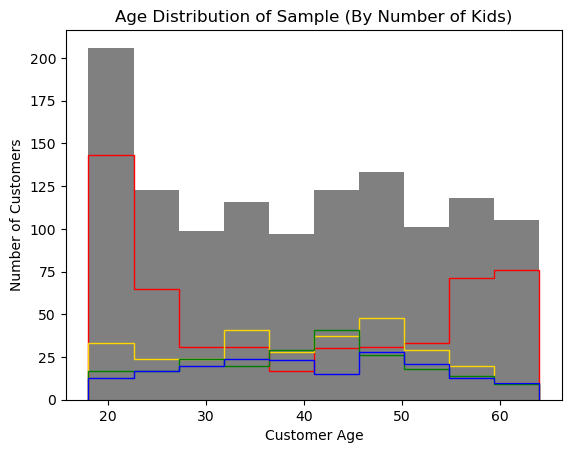

In [21]:
counts, bins = numpy.histogram(wm_ages)
plt.title("Age Distribution of Sample (By Number of Kids)")
plt.xlabel("Customer Age")
plt.ylabel("Number of Customers")
plt.stairs(counts, bins, fill=True, fc="gray")

wm_age_zero = [] 
wm_age_one = [] 
wm_age_two = [] 
wm_age_more = [] 
for entry in wellmodeled_insurance_dict:
    row = wellmodeled_insurance_dict[entry]
    if (row["children"] == 0):
        wm_age_zero.append(row["age"])
    elif row["children"] == 1:
        wm_age_one.append(row["age"])
    elif row["children"] == 2:
        wm_age_two.append(row["age"])
    else:
        wm_age_more.append(row["age"])
        
counts, bins = numpy.histogram(wm_age_zero)
plt.stairs(counts, bins, ec="red")

counts, bins = numpy.histogram(wm_age_one)
plt.stairs(counts, bins, ec="gold")

counts, bins = numpy.histogram(wm_age_two)
plt.stairs(counts, bins, ec="green")

counts, bins = numpy.histogram(wm_age_more)
plt.stairs(counts, bins, ec="blue")
plt.show()

Yep.  And it looks like I'm going to stick to 0 to 3+ kids as the really large families are rare.  So, the goal is to get the 'wellmodled' data set and get averages by sex, region and number of children

In [22]:
middlewm_insurance_dict = {}
for entry in wellmodeled_insurance_dict:
    row = wellmodeled_insurance_dict[entry]
    if (row["age"] >= 30 and row["age"]<=50):
        middlewm_insurance_dict[entry] = row

female_avg = 0.
female_count = 0
male_avg = 0.
male_count = 0
ne_avg = 0.
ne_count = 0
nw_avg = 0.
nw_count = 0
se_avg = 0.
se_count = 0
sw_avg = 0.
sw_count = 0
zerokids_avg = 0.
zerokids_count= 0
onekid_avg = 0.
onekid_count= 0
twokids_avg = 0.
twokids_count= 0
manykids_avg = 0.
manykids_count= 0
for entry in middlewm_insurance_dict:
    row = middlewm_insurance_dict[entry]
    if (row["sex"]== "female"):
        female_avg += row["charges"]-insurance_estimate_v3dot1(row)
        female_count +=1
    else:
        male_avg += row["charges"]-insurance_estimate_v3dot1(row)
        male_count +=1     
    if (row["region"]== "northeast"):
        ne_avg += row["charges"]-insurance_estimate_v3dot1(row)
        ne_count +=1
    elif (row["region"]== "northwest"):
        nw_avg += row["charges"]-insurance_estimate_v3dot1(row)
        nw_count +=1
    elif (row["region"]== "southwest"):
        sw_avg += row["charges"]-insurance_estimate_v3dot1(row)
        sw_count +=1
    else:
        se_avg += row["charges"]-insurance_estimate_v3dot1(row)
        se_count +=1
    if (row["children"]== 0):
        zerokids_avg += row["charges"]-insurance_estimate_v3dot1(row)
        zerokids_count +=1
    elif (row["children"]== 1):
        onekid_avg += row["charges"]-insurance_estimate_v3dot1(row)
        onekid_count +=1
    elif (row["children"]== 2):
        twokids_avg += row["charges"]-insurance_estimate_v3dot1(row)
        twokids_count +=1
    elif (row["children"]== 3):
        manykids_avg += row["charges"]-insurance_estimate_v3dot1(row)
        manykids_count +=1

female_coeff = female_avg/female_count - male_avg/male_count
female_avg = female_avg/female_count
male_avg = male_avg/male_count
se_avg = se_avg/se_count
sw_coeff = sw_avg/sw_count-se_avg
sw_avg = sw_avg/sw_count
nw_coeff = nw_avg/nw_count-se_avg
nw_avg = nw_avg/nw_count
ne_coeff = ne_avg/ne_count-se_avg
ne_coeff = ne_avg/ne_count

kids_cost = [zerokids_avg/zerokids_count,onekid_avg/onekid_count,twokids_avg/twokids_count,manykids_avg/manykids_count]
kids_num = [0,1,2,3.]
wm_kids_coeff= numpy.polyfit(kids_num,kids_cost, deg = 1)

So, females pay on average 385 dollars more for insurance than males (adjusting for smoker status and BMI).  People in the Southeast pay the least for insurance, with the other regions paying 59 dollars (Southwest), 463 dollars (Northwest) or 634 dollars(Northeast) more. 

Strictly speaking it would probably be better to do this as a percentage for region, as it seems likely this scales with cost.  That would mean going back to the full data, unadjusted and dealing with regional differences in BMI and smoker status.  For now, I proceed, noting this source of error.

The kids data is nice and linear.  I can just fit a line here, which actually solves the 'more than three kids' problem. 

Next test is to re-do the function.  Let's plot with smoking status and gender to confirm that it is not a percentage.

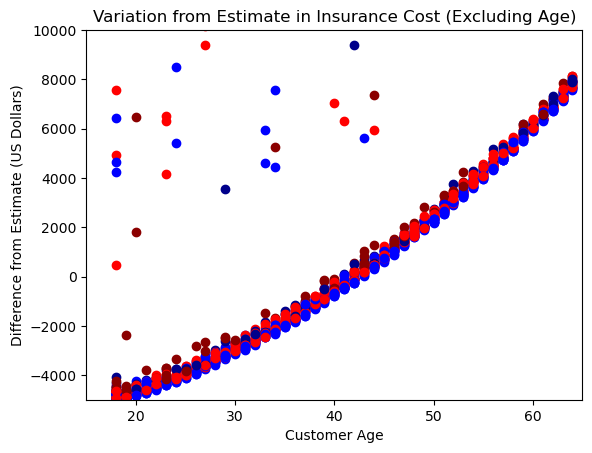

[ 539.02139824 -874.88785591]


In [23]:
def insurance_estimate_v3dot3(insurance_entry):
    if (insurance_entry["sex"] == "female"):
        working_estimate = female_coeff
    else: 
        working_estimate = 0.
    if (insurance_entry["region"] == "northeast"):
        working_estimate += ne_coeff
    elif (insurance_entry["region"] == "northwest"):
        working_estimate += nw_coeff
    elif (insurance_entry["region"] == "southwest"):
        working_estimate += sw_coeff
    working_estimate += wm_kids_coeff[0]*insurance_entry["children"] + wm_kids_coeff[1]
    if (insurance_entry["smoker"] == "yes"):
        if (row["bmi"] <= 30.):
            working_estimate +=  wm_smoker_lowbmi_coeff[0]*insurance_entry["bmi"]+wm_smoker_lowbmi_coeff[1]
        else:
            working_estimate +=   wm_smoker_highbmi_coeff[0]*insurance_entry["bmi"]+wm_smoker_highbmi_coeff[1]
    else:
        working_estimate +=   wm_nonsmoker_coeff[1]        
    return working_estimate

plt.xlim([15,65])
plt.ylim([-5000,10000])
plt.title("Variation from Estimate in Insurance Cost (Excluding Age)")
plt.xlabel("Customer Age")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v3dot3(row)
    if (row["smoker"] == "no" and row["sex"] == "female"):
        plt.scatter(row["age"],row["charges"]-est_cost,c = "red")
    elif (row["smoker"] == "no" and row["sex"] == "male"):
        plt.scatter(row["age"],row["charges"]-est_cost,c = "blue")
    elif (row["smoker"] == "yes" and row["sex"] == "female"):
        plt.scatter(row["age"],row["charges"]-est_cost,c = "darkred")
    else:
        plt.scatter(row["age"],row["charges"]-est_cost,c = "darkblue")
        
plt.show()
print(wm_kids_coeff)

By eye, I think this one is still a bit off on some of the corrections, but it is pretty nice.  We could fit all the variables at once, but let's see how we do by just single variable fits.  I'm going to try to get an exponential fit again, but if it fails, we'll approximate with a polynomial of enough degrees to fake it.

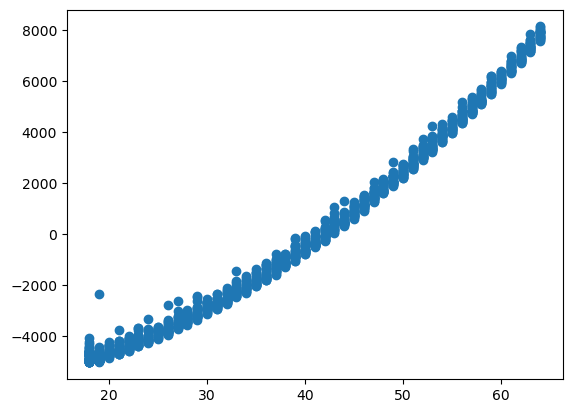

[ 5.25721179e-04 -8.60107826e-02  8.27822602e+00 -1.14450027e+02
 -5.03417263e+03]


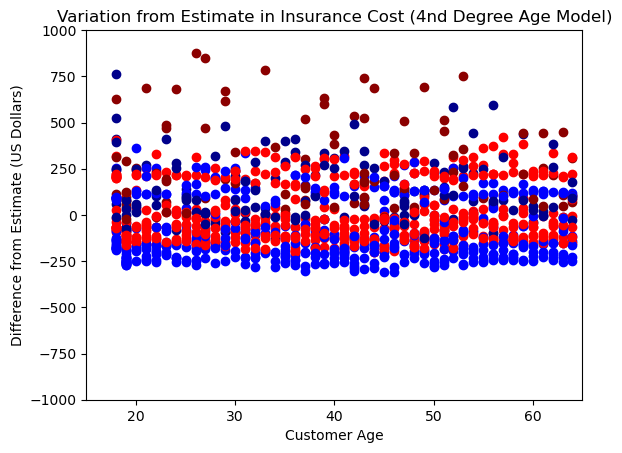

In [24]:
cost_variation_v4 = []
wm_ages = []

for entry in wellmodeled_insurance_dict:
    row = wellmodeled_insurance_dict[entry]
    est_cost = insurance_estimate_v3dot3(row)
    wm_ages.append(row["age"])
    cost_variation_v4.append(row["charges"]-est_cost)
    
plt.scatter(wm_ages,cost_variation_v4)
plt.show()

def monoExp(x, a, b, c):
    return a * numpy.exp(b * x) + c
    
temp_coeff, temp_covar = spo.curve_fit(monoExp,wm_ages,cost_variation_v4)
#print(temp_coeff)

#Nope, we still get the constant function when we fit it.  I need to look into this.

wm_age_coeff = numpy.polyfit(wm_ages,cost_variation_v4, deg = 4)
print (wm_age_coeff)

def insurance_estimate_v4dot0(insurance_entry):
    if (insurance_entry["sex"] == "female"):
        working_estimate = female_coeff
    else: 
        working_estimate = 0
    if (insurance_entry["region"] == "northeast"):
        working_estimate += ne_coeff
    elif (insurance_entry["region"] == "northwest"):
        working_estimate += nw_coeff
    elif (insurance_entry["region"] == "southwest"):
        working_estimate += sw_coeff
    working_estimate += wm_kids_coeff[0]*insurance_entry["children"] + wm_kids_coeff[1]
    if (insurance_entry["smoker"] == "yes"):
        if (row["bmi"] <= 30.):
            working_estimate +=  wm_smoker_lowbmi_coeff[0]*insurance_entry["bmi"]+wm_smoker_lowbmi_coeff[1]
        else:
            working_estimate +=   wm_smoker_highbmi_coeff[0]*insurance_entry["bmi"]+wm_smoker_highbmi_coeff[1]
    else:
        working_estimate +=   wm_nonsmoker_coeff[1]   
    age = insurance_entry["age"]
    working_estimate += wm_age_coeff[0]*age**4+wm_age_coeff[1]*age**3+wm_age_coeff[2]*age**2+wm_age_coeff[3]*age**1+wm_age_coeff[4]
    return working_estimate

plt.xlim([15,65])
plt.ylim([-1000,1000])
plt.title("Variation from Estimate in Insurance Cost (4nd Degree Age Model)")
plt.xlabel("Customer Age")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v4dot0(row)
    if (row["smoker"] == "no" and row["sex"] == "female"):
        plt.scatter(row["age"],row["charges"]-est_cost,c = "red")
    elif (row["smoker"] == "no" and row["sex"] == "male"):
        plt.scatter(row["age"],row["charges"]-est_cost,c = "blue")
    elif (row["smoker"] == "yes" and row["sex"] == "female"):
        plt.scatter(row["age"],row["charges"]-est_cost,c = "darkred")
    else:
        plt.scatter(row["age"],row["charges"]-est_cost,c = "darkblue")
        
plt.show()

A quartic appears to be good enough.  For the final version, I'm going to look at the cheapest of the categories (male, zero kids, from the southeast), to get the baselines for those categories, and then add in the categorical effects, But we're already at a place where the estimate is pretty good. 

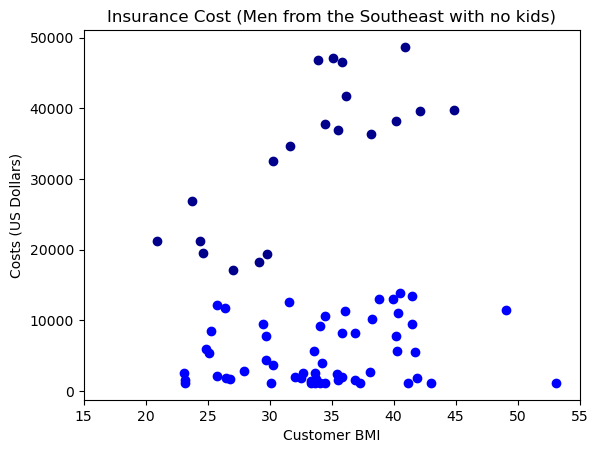

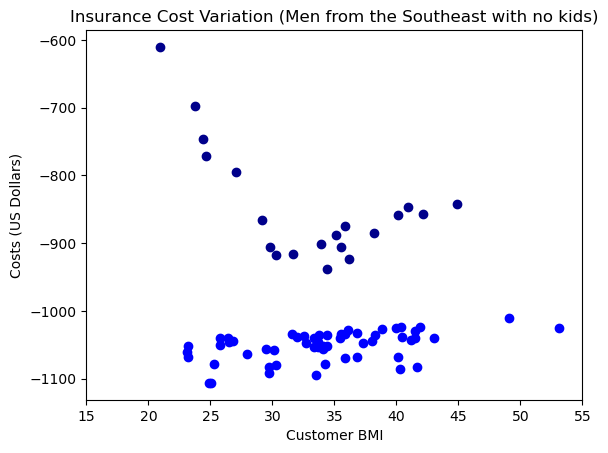

In [29]:
def insurance_estimate_v4dot1(insurance_entry):
    working_estimate = 0
    if (insurance_entry["smoker"] == "yes"):
        if (row["bmi"] <= 30.):
            working_estimate +=  wm_smoker_lowbmi_coeff[0]*insurance_entry["bmi"]+wm_smoker_lowbmi_coeff[1]
        else:
            working_estimate +=   wm_smoker_highbmi_coeff[0]*insurance_entry["bmi"]+wm_smoker_highbmi_coeff[1]
    else:
        working_estimate +=   wm_nonsmoker_coeff[1]   
    age = insurance_entry["age"]
    working_estimate += wm_age_coeff[0]*age**4+wm_age_coeff[1]*age**3+wm_age_coeff[2]*age**2+wm_age_coeff[3]*age**1+wm_age_coeff[4]
    return working_estimate

cost_variation_v5 = []
wm_ages = []

plt.xlim([15,55])
plt.title("Insurance Cost (Men from the Southeast with no kids)")
plt.xlabel("Customer BMI")
plt.ylabel("Costs (US Dollars)")
for entry in wellmodeled_insurance_dict:
    row = wellmodeled_insurance_dict[entry]
    if (row["sex"]=="male" and row["region"]=="southeast" and row['children'] == 0):
        if (row["smoker"] == "no"):
            plt.scatter(row["bmi"],row["charges"],c = "blue")
        else:
            plt.scatter(row["bmi"],row["charges"],c = "darkblue")
    
plt.show()

plt.xlim([15,55])
plt.title("Insurance Cost Variation (Men from the Southeast with no kids)")
plt.xlabel("Customer BMI")
plt.ylabel("Costs (US Dollars)")
for entry in wellmodeled_insurance_dict:
    row = wellmodeled_insurance_dict[entry]
    if (row["sex"]=="male" and row["region"]=="southeast" and row['children'] == 0):
        est_cost = insurance_estimate_v4dot1(row)
        wm_ages.append(row["age"])
        cost_variation_v5.append(row["charges"]-est_cost)
        if (row["smoker"] == "no"):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "blue")
        else:
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "darkblue")
    
plt.show()

Well, nuts, I have to redo the estimates.  Let's test how well this works.  (It also might be that there's a linear trend in BMI even for non-smokers, but it's weak.)

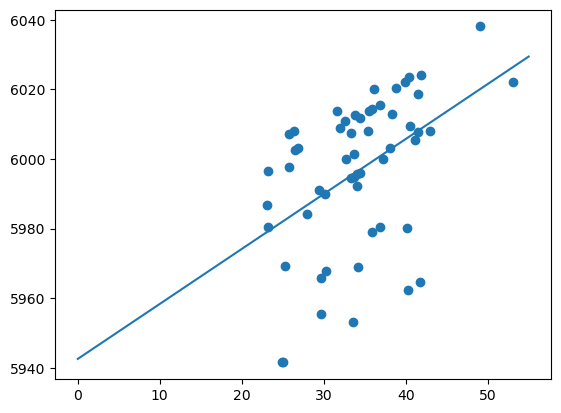

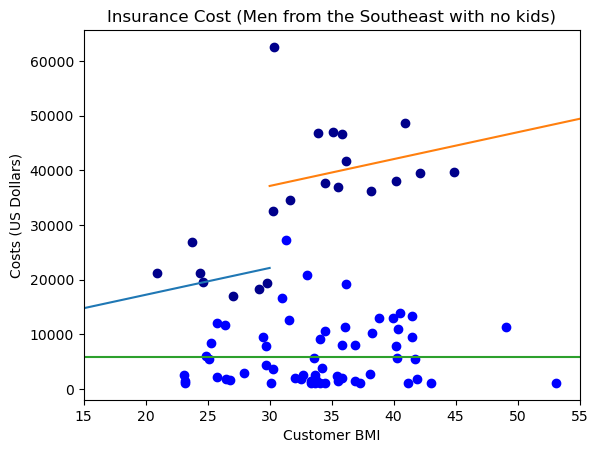

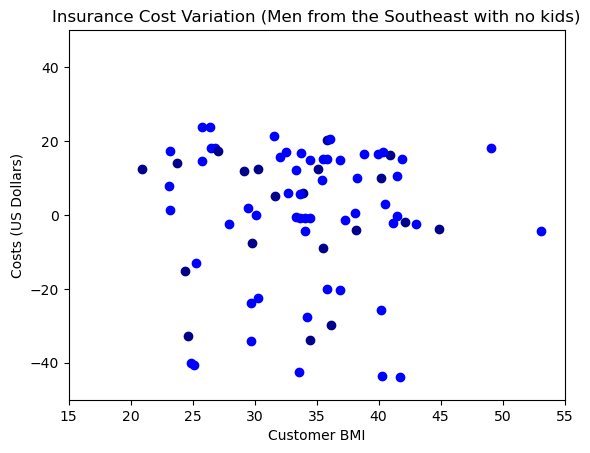

In [62]:
def insurance_estimate_v4dot2(insurance_entry):
    age = insurance_entry["age"]
    working_estimate = wm_age_coeff[0]*age**4+wm_age_coeff[1]*age**3+wm_age_coeff[2]*age**2+wm_age_coeff[3]*age**1+wm_age_coeff[4]
    return working_estimate
cost1 = []
bmi1 = []
cost2 = []
bmi2 = []
cost3 = []
bmi3 = []

for entry in wellmodeled_insurance_dict:
    row = wellmodeled_insurance_dict[entry]
    if (row["sex"]=="male" and row["region"]=="southeast" and row['children'] == 0):
        est_cost_age = insurance_estimate_v4dot2(row)
        if (row["smoker"] == "yes"):
            if (row["bmi"] <= 30.):
                cost2.append(row["charges"]-est_cost_age)
                bmi2.append(row["bmi"])
            else:
                cost3.append(row["charges"]-est_cost_age)
                bmi3.append(row["bmi"])
        else:
            cost1.append(row["charges"]-est_cost_age)
            bmi1.append(row["bmi"])
        
nonsmoker_coeff2 = []
            
smoker_lowbmi_coeff2 = numpy.polyfit(bmi2,cost2, deg = 1)
smoker_highbmi_coeff2 = numpy.polyfit(bmi3,cost3, deg = 1)
nonsmoker_coeff2 = numpy.polyfit(bmi1,cost1, deg = 1)

plt.scatter(bmi1,cost1)
plt.plot([0,55], [nonsmoker_coeff2[1],nonsmoker_coeff2[1]+nonsmoker_coeff2[0]*55.])  
plt.show()

def insurance_estimate_v4dot3(insurance_entry):
    age = insurance_entry["age"]
    working_estimate = wm_age_coeff[0]*age**4+wm_age_coeff[1]*age**3+wm_age_coeff[2]*age**2+wm_age_coeff[3]*age**1+wm_age_coeff[4]
    if (insurance_entry["smoker"] == "yes"):
        if (row["bmi"] <= 30.):
            working_estimate +=  smoker_lowbmi_coeff2[0]*insurance_entry["bmi"]+smoker_lowbmi_coeff2[1]
        else:
            working_estimate +=   smoker_highbmi_coeff2[0]*insurance_entry["bmi"]+smoker_highbmi_coeff2[1]
    else:
        working_estimate +=   nonsmoker_coeff2[1] +nonsmoker_coeff2[0]*insurance_entry["bmi"]
    return working_estimate


plt.xlim([15,55])
plt.title("Insurance Cost (Men from the Southeast with no kids)")
plt.xlabel("Customer BMI")
plt.ylabel("Costs (US Dollars)")
for entry in insurance_dict:
    row = insurance_dict[entry]
    if (row["sex"]=="male" and row["region"]=="southeast" and row['children'] == 0):
        if (row["smoker"] == "no"):
            plt.scatter(row["bmi"],row["charges"],c = "blue")
        else:
            plt.scatter(row["bmi"],row["charges"],c = "darkblue")
        
plt.plot([0,30], [smoker_lowbmi_coeff[1],smoker_lowbmi_coeff[0]*30+smoker_lowbmi_coeff[1]])        
plt.plot([30,55], [smoker_highbmi_coeff[1]+smoker_highbmi_coeff[0]*30,smoker_highbmi_coeff[0]*55+smoker_highbmi_coeff[1]])        
plt.plot([0,55], [nonsmoker_coeff2[1],nonsmoker_coeff2[1]])        

plt.show()

plt.xlim([15,55])
plt.ylim([-50,50])
plt.title("Insurance Cost Variation (Men from the Southeast with no kids)")
plt.xlabel("Customer BMI")
plt.ylabel("Costs (US Dollars)")
for entry in insurance_dict:
    row = insurance_dict[entry]
    if (row["sex"]=="male" and row["region"]=="southeast" and row['children'] == 0):
        est_cost = insurance_estimate_v4dot3(row)
        wm_ages.append(row["age"])
        cost_variation_v5.append(row["charges"]-est_cost)
        if (row["smoker"] == "no"):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "blue")
        else:
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "darkblue")
    
plt.show()

Problem solved!  Now to test how this works on groups with one variation (so childless women from the southeast, childless men from all over the country, and men with children from the southeast)

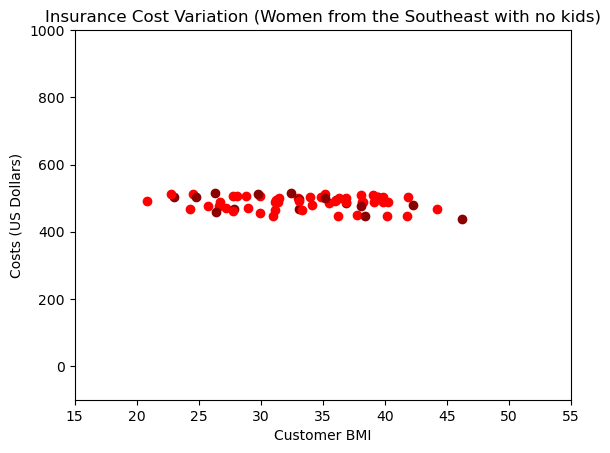

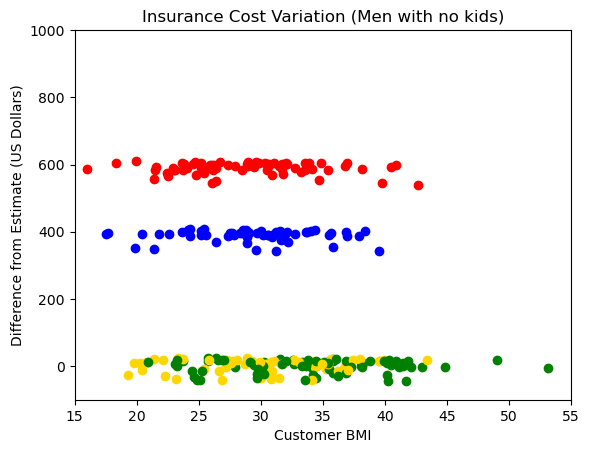

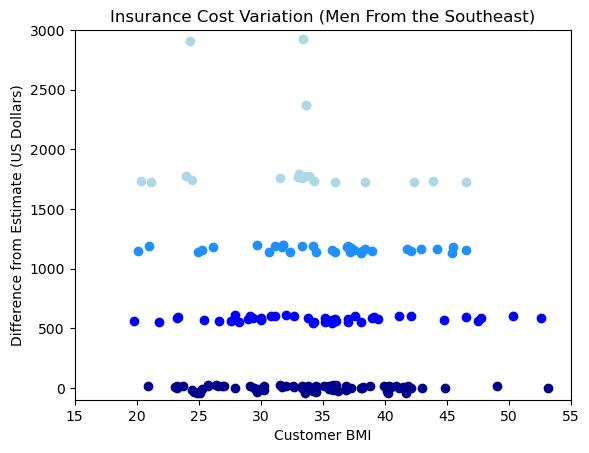

In [74]:
plt.xlim([15,55])
plt.ylim([-100,1000])
plt.title("Insurance Cost Variation (Women from the Southeast with no kids)")
plt.xlabel("Customer BMI")
plt.ylabel("Costs (US Dollars)")
for entry in insurance_dict:
    row = insurance_dict[entry]
    if (row["sex"]=="female" and row["region"]=="southeast" and row['children'] == 0):
        est_cost = insurance_estimate_v4dot3(row)
        wm_ages.append(row["age"])
        cost_variation_v5.append(row["charges"]-est_cost)
        if (row["smoker"] == "no"):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "red")
        else:
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "darkred")
    
plt.show()

plt.xlim([15,55])
plt.ylim([-100,1000])
plt.title("Insurance Cost Variation (Men with no kids)")
plt.xlabel("Customer BMI")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    if (row["sex"]=="male" and row['children'] == 0):
        est_cost = insurance_estimate_v4dot3(row)
        if (row["region"] == "northeast"):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "red")
        elif (row["region"] == "southeast"):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "green")
        elif (row["region"] == "southwest"):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "gold")
        else:
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "blue")
plt.show()

plt.xlim([15,55])
plt.ylim([-100,3000])
plt.title("Insurance Cost Variation (Men From the Southeast)")
plt.xlabel("Customer BMI")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    if (row["sex"]=="male" and row['region'] == "southeast"):
        est_cost = insurance_estimate_v4dot3(row)
        if (row["children"] == 0):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "darkblue")
        elif (row["children"] == 1):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "blue")
        elif (row["children"] == 2):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "dodgerblue")
        else:
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "lightblue")
plt.show()

So, we have women from the southeast paying about 500 dollars more for insurance, men from the northwest paying about 400 dollars more and men from the northeast paying 600 dollars more.  The adjsutment for number of kids appears to be linear again.  

In [81]:
female_total = 0.
female_count = 0.
ne_total = 0.
ne_count = 0.
nw_total = 0.
nw_count = 0.
sw_total = 0.
sw_count = 0.
base_total = 0.
base_count = 0.
one_total = 0.
one_count = 0.
two_total = 0.
two_count = 0.
three_total = 0.
three_count = 0.

for entry in wellmodeled_insurance_dict:
    row = wellmodeled_insurance_dict[entry]
    est_cost = insurance_estimate_v4dot3(row)
    if (row["region"]=="southeast" and row['children'] == 0 and row["sex"]=="male"):
        base_total += row["charges"] - est_cost
        base_count += 1
    elif (row["region"]=="southeast" and row['children'] == 0 and row["sex"]=="female"):
        female_total += row["charges"] - est_cost
        female_count += 1
    elif (row["region"]=="northeast" and row['children'] == 0 and row["sex"]=="male"):
        ne_total += row["charges"] - est_cost
        ne_count += 1
    elif (row["region"]=="northwest" and row['children'] == 0 and row["sex"]=="male"):
        nw_total += row["charges"] - est_cost
        nw_count += 1
    elif (row["region"]=="southwest" and row['children'] == 0 and row["sex"]=="male"):
        sw_total += row["charges"] - est_cost
        sw_count += 1
    elif (row["region"]=="southeast" and row['children'] == 1 and row["sex"]=="male"):
        one_total += row["charges"] - est_cost
        one_count += 1
    elif (row["region"]=="southeast" and row['children'] == 2 and row["sex"]=="male"):
        two_total += row["charges"] - est_cost
        two_count += 1
    elif (row["region"]=="southeast" and row['children'] == 3 and row["sex"]=="male"):
        three_total += row["charges"] - est_cost
        three_count += 1
        
base_avg = base_total/base_count
female_avg = female_total/female_count
nw_avg = nw_total/nw_count
sw_avg = sw_total/sw_count
ne_avg = ne_total/ne_count
one_avg = one_total/one_count
two_avg = two_total/two_count
three_avg = three_total/three_count

kids_coeff= numpy.polyfit([0.,1.,2.,3.],[0.,one_avg,two_avg,three_avg], deg = 1)

print(base_avg,female_avg)

print(ne_avg,nw_avg,sw_avg)

print(kids_coeff)

2.0942312211876637e-13 486.58403418547294
589.4110563512187 388.76931448258284 2.3648638867201224
[583.32942619  -2.30089351]


Good, the base set average is close to zero.  The southwest is also close enough to be within error.  We have that childless women in the southeast are charged 487 dollars more, northeastern childless men are charged 589 dollars more, northwestern childless men are charged 389 dollars more, and southeastern men are charged 583 dollars more per child.

Now we add this to the algorithm and see if the groups that only share one trait with the base group work.  That means we need to test 'all men', 'all people from the southeast' and 'all childless people'.

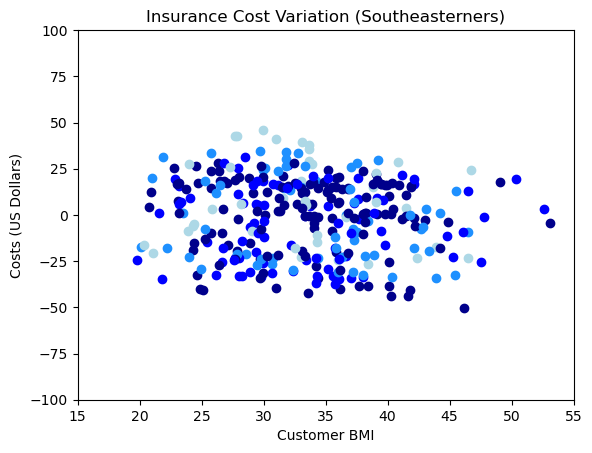

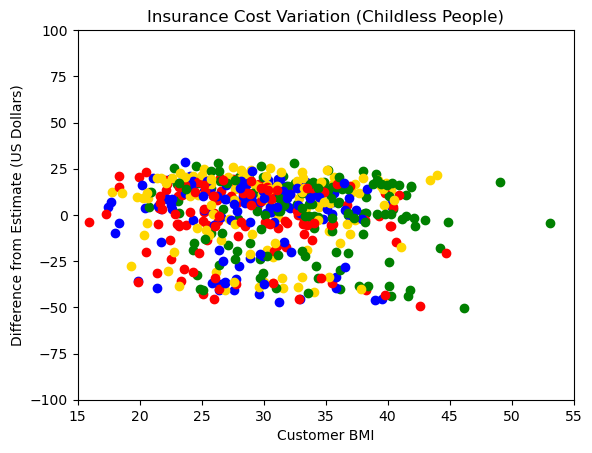

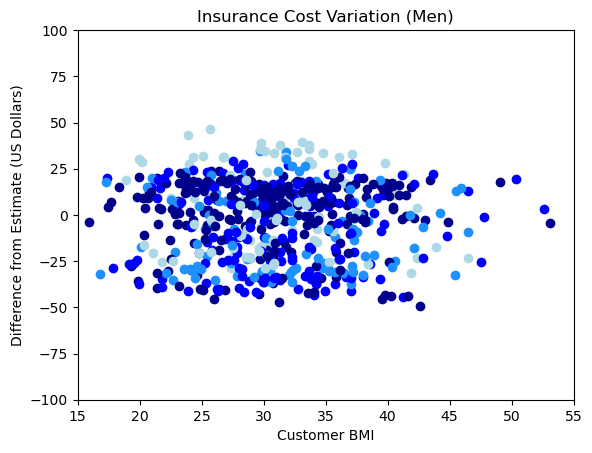

In [84]:
def insurance_estimate_v4dot4(insurance_entry):
    age = insurance_entry["age"]
    working_estimate = wm_age_coeff[0]*age**4+wm_age_coeff[1]*age**3+wm_age_coeff[2]*age**2+wm_age_coeff[3]*age**1+wm_age_coeff[4]
    if (insurance_entry["smoker"] == "yes"):
        if (row["bmi"] <= 30.):
            working_estimate +=  smoker_lowbmi_coeff2[0]*insurance_entry["bmi"]+smoker_lowbmi_coeff2[1]
        else:
            working_estimate +=   smoker_highbmi_coeff2[0]*insurance_entry["bmi"]+smoker_highbmi_coeff2[1]
    else:
        working_estimate +=   nonsmoker_coeff2[1] +nonsmoker_coeff2[0]*insurance_entry["bmi"]
    working_estimate += kids_coeff[0]*insurance_entry["children"]
    if (insurance_entry["sex"] == "female"):
        working_estimate += female_avg
    if (insurance_entry["region"] == "northeast"):
        working_estimate += ne_avg
    elif (insurance_entry["region"] == "northwest"):
        working_estimate += nw_avg
    return working_estimate

plt.xlim([15,55])
plt.ylim([-100,100])
plt.title("Insurance Cost Variation (Southeasterners)")
plt.xlabel("Customer BMI")
plt.ylabel("Costs (US Dollars)")
for entry in insurance_dict:
    row = insurance_dict[entry]
    if (row["region"]=="southeast"):
        est_cost = insurance_estimate_v4dot4(row)
        if (row["children"] == 0):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "darkblue")
        elif (row["children"] == 1):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "blue")
        elif (row["children"] == 2):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "dodgerblue")
        else:
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "lightblue")
    
plt.show()

plt.xlim([15,55])
plt.ylim([-100,100])
plt.title("Insurance Cost Variation (Childless People)")
plt.xlabel("Customer BMI")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    if (row['children'] == 0):
        est_cost = insurance_estimate_v4dot4(row)
        if (row["region"] == "northeast"):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "red")
        elif (row["region"] == "southeast"):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "green")
        elif (row["region"] == "southwest"):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "gold")
        else:
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "blue")
plt.show()

plt.xlim([15,55])
plt.ylim([-100,100])
plt.title("Insurance Cost Variation (Men)")
plt.xlabel("Customer BMI")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    if (row["sex"]=="male"):
        est_cost = insurance_estimate_v4dot4(row)
        if (row["children"] == 0):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "darkblue")
        elif (row["children"] == 1):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "blue")
        elif (row["children"] == 2):
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "dodgerblue")
        else:
            plt.scatter(row["bmi"],row["charges"]-est_cost,c = "lightblue")
plt.show()

Oh, that's very nice.  Let's do the final plot and confirm the variation is less than 100, then quantify this thing.

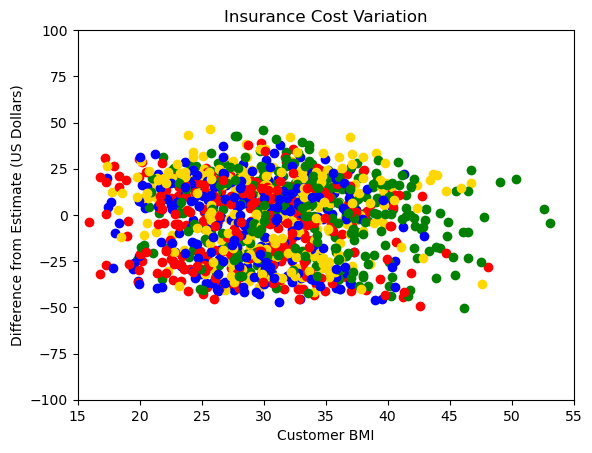

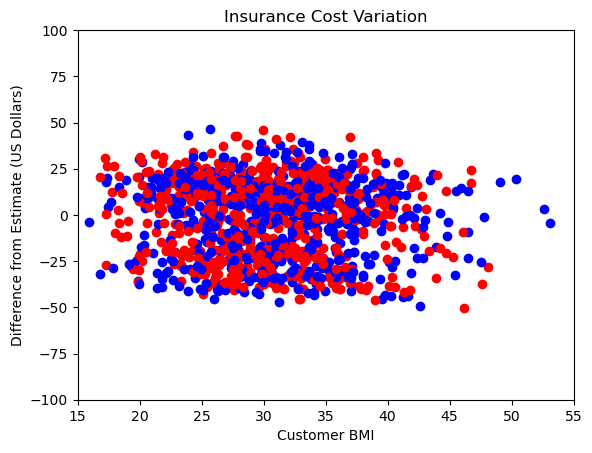

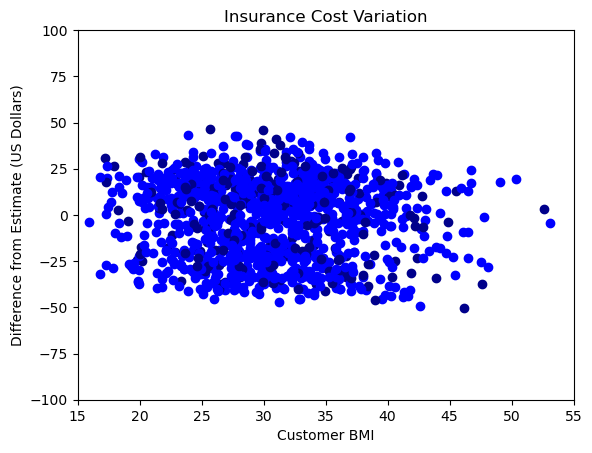

In [93]:
plt.xlim([15,55])
plt.ylim([-100,100])
plt.title("Insurance Cost Variation")
plt.xlabel("Customer BMI")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v4dot4(row)
    if (row["region"] == "northeast"):
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "red")
    elif (row["region"] == "southeast"):
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "green")
    elif (row["region"] == "southwest"):
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "gold")
    else:
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "blue")
plt.show()

plt.xlim([15,55])
plt.ylim([-100,100])
plt.title("Insurance Cost Variation")
plt.xlabel("Customer BMI")
plt.ylabel("Difference from Estimate (US Dollars)")

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v4dot4(row)
    if (row["sex"] == "female"):
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "red")
    else:
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "blue")
plt.show()

plt.xlim([15,55])
plt.ylim([-100,100])
plt.title("Insurance Cost Variation")
plt.xlabel("Customer BMI")
plt.ylabel("Difference from Estimate (US Dollars)")
for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate_v4dot4(row)
    if (row["smoker"] == "yes"):
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "darkblue")
    else:
        plt.scatter(row["bmi"],row["charges"]-est_cost,c = "blue")
plt.show()

In [94]:
def insurance_estimate(insurance_entry):
    age = insurance_entry["age"]
    working_estimate = wm_age_coeff[0]*age**4+wm_age_coeff[1]*age**3+wm_age_coeff[2]*age**2+wm_age_coeff[3]*age**1+wm_age_coeff[4]
    if (insurance_entry["smoker"] == "yes"):
        if (row["bmi"] <= 30.):
            working_estimate +=  smoker_lowbmi_coeff2[0]*insurance_entry["bmi"]+smoker_lowbmi_coeff2[1]
        else:
            working_estimate +=   smoker_highbmi_coeff2[0]*insurance_entry["bmi"]+smoker_highbmi_coeff2[1]
    else:
        working_estimate +=   nonsmoker_coeff2[1] +nonsmoker_coeff2[0]*insurance_entry["bmi"]
    working_estimate += kids_coeff[0]*insurance_entry["children"]
    if (insurance_entry["sex"] == "female"):
        working_estimate += female_avg
    if (insurance_entry["region"] == "northeast"):
        working_estimate += ne_avg
    elif (insurance_entry["region"] == "northwest"):
        working_estimate += nw_avg
    return working_estimate

difference_from_estimate = []
wm_difference_from_estimate = []

for entry in insurance_dict:
    row = insurance_dict[entry]
    est_cost = insurance_estimate(row)
    difference_from_estimate.append(row["charges"]-est_cost)
    
est_avg = numpy.mean(difference_from_estimate)
est_stdev = numpy.std(difference_from_estimate)

print(est_avg,est_stdev)

for entry in wellmodeled_insurance_dict:
    row = wellmodeled_insurance_dict[entry]
    est_cost = insurance_estimate(row)
    wm_difference_from_estimate.append(row["charges"]-est_cost)
    
wm_est_avg = numpy.mean(wm_difference_from_estimate)
wm_est_stdev = numpy.std(wm_difference_from_estimate)

print(wm_est_avg,wm_est_stdev)

1275.439694384014 4354.453043608793
0.06803840924709145 71.52369622556515


So, if the customer in question doesn't have any unusual health problems, we can expect to predict their health insurance cost to within about 70 dollars, and are just as likely to underestimate as overestimate.  For the average customer, we'll underestimate the cost by 1300 dollars, and have an error of 4300 dollars.  This is not great, but there is a limit to what we can do with the data at hand.  Time to put the data input and final function in a normal python file and prepare a report for outsiders. 